# Expectation Value Experiments

* Christopher Wood
* Sep 3, 2020

## Expectation Values

Many quantum computing experiments and applications rely on estimating expecation values.

Given an operator $O$, this is an experiment to estimate $\langle O \rangle = Tr[\rho.O]$.

The variance in the estimate is given by $\sigma^2 = \langle O^2 \rangle - \langle O \rangle^2$, and standard error by $\epsilon = \sigma / \sqrt{N}$, where $N$ is the number of samples (shots).

In [1]:
import numpy as np
import qiskit.quantum_info as qi

seed = 1000
num_qubits = 1

# Construct a random Hermitian Operator
op = qi.random_hermitian(2 ** num_qubits, seed=seed)

# Construct a random statevector
state = qi.random_statevector(2 ** num_qubits, seed=seed)

# Compute the exact expectation value
expval = state.expectation_value(op).real

# Compute the exact standard error
shots = 1000
variance = state.expectation_value(op.dot(op)).real - expval ** 2
stderror = np.sqrt(variance / shots)

print('⟨𝑂⟩ = {:.3f} \u00B1 {:.3f}'.format(expval, stderror))

⟨𝑂⟩ = -1.457 ± 0.024


## Expectation Values from Counts

We introduce a function `expectation_value` that can return the expectation value and standard error computed from a counts dictionary. It has signature

```python
expectation_value(counts,
                  diagonal=None,
                  clbits=None,
                  mitigator=None,
                  mitigator_qubits=None
```

* The diagonal allows specifying a custom diagonal for an operator $O = \sum_i O_i |i\rangle\langle i|$. If `None` the diagonal will be set to $O = Z^{\otimes n}$.
* Clbits allows marginalizing over counts to specific classical bits (Note: this can also be done using the diagonal kwarg by making the diagonal on marginal qubits correspond to the identity)
* Mitigator allows passing in a `Mitigator` object to apply measurement error mitigation (we will show this later)
* Mitogator qubits specifies which physical qubits the clbits correspond to so the correct mitigation parameters are applied

In [2]:
from qiskit.ignis.experiments import expectation_value

counts = state.sample_counts(1000)
ev, everror = expectation_value(counts)
print('⟨Z⟩ = {:.3f} \u00B1 {:.3f}'.format(ev, everror))

⟨Z⟩ = 0.168 ± 0.031


## Expectation Value Experiments

To make it easier to convert arbitrary operators and states into circuits for computing expectation values we introduce an `ExpectationValue` experiment class. The *experiment* part is how this is converted to quantum circuits and computed from count results.

The default method is to perform Pauli-basis measurements by first converting $O$ into a `SparsePauliOp`
$O = \sum_i c_i P_i$ and construct a measurement circuit for each $P_i$.

The resulting counts from each Pauli basis measurement are be converted to expectation values using the above `expectation_value` function. This analysis of results is automated by the `ExpectationValueAnalysis` class

In [3]:
from qiskit.ignis.experiments import ExpectationValue
from qiskit.providers.aer import QasmSimulator

# Create an expectation
exp = ExpectationValue(op, initial_state=state)

# Run on a backend
expval_sim, stderror_sim = exp.run(QasmSimulator(), shots=1000)

print('⟨𝑂⟩ = {:.3f} \u00B1 {:.3f}'.format(expval_sim, stderror_sim))

⟨𝑂⟩ = -1.469 ± 0.027


An experiment consists of a list of circuits and a list of metadata that can be used to analyze the results.

In [4]:
from pprint import pprint
for circ, meta in zip(exp.generator.circuits(), exp.generator.metadata()):
    pprint(meta)
    print(circ.draw())

{'basis': 'I',
 'coeff': (-0.4034958421323671+0j),
 'exp_id': '0e860ceb-de1f-4de1-8431-26b7d822a9a5',
 'method': 'Pauli',
 'name': 'expval',
 'qubits': [0]}
     ┌──────────────────────────────────────────────┐ ░ ┌─┐
q_0: ┤ initialize(-0.7382+0.1363j,0.19129+0.63237j) ├─░─┤M├
     └──────────────────────────────────────────────┘ ░ └╥┘
c: 1/════════════════════════════════════════════════════╩═
                                                         0 
{'basis': 'X',
 'coeff': (0.8400290642939854+0j),
 'exp_id': '0e860ceb-de1f-4de1-8431-26b7d822a9a5',
 'method': 'Pauli',
 'name': 'expval',
 'qubits': [0]}
     ┌──────────────────────────────────────────────┐┌───┐ ░ ┌─┐
q_0: ┤ initialize(-0.7382+0.1363j,0.19129+0.63237j) ├┤ H ├─░─┤M├
     └──────────────────────────────────────────────┘└───┘ ░ └╥┘
c: 1/═════════════════════════════════════════════════════════╩═
                                                              0 
{'basis': 'Y',
 'coeff': (0.9852634410528578+0j),
 'exp_id': '

## Expectation Value Measurement Error Mitigation

Real experiments have measurement noise that must be dealt with to get more accurate estimates of expectation values.

Ignis will include 3 types of measurement error mitigation:

* Full A-matrix mitigation
* Single-qubit tensor product A-matrix mitigation
* CTMP mitigation

To apply mitigation we must first perform an experiment to calibrate a measurement `Mitigator` object, which can then be used to apply mitigation in an `ExpectationValue` experiment

In [5]:
from qiskit.test.mock import FakeBoeblingen
from qiskit.providers.aer.noise import NoiseModel

# Create a noisy Mock simulator backend
backend = FakeBoeblingen()
sim = QasmSimulator()
noise_model = NoiseModel.from_backend(backend,
                                      warnings=False)
sim.configuration().basis_gates = noise_model.basis_gates

### CTMP Mitigation calibration experiment

We will now consider an example where we calibrate a 4-qubit CTMP mitigator

In [6]:
from qiskit.ignis.experiments import MeasMitigation, MeasMitigationAnalysis

num_qubits = 4
mit_cal = MeasMitigation(num_qubits, method='CTMP')
mitigator = mit_cal.run(sim, noise_model=noise_model)

The output of this experiment is a `Mitigator` object which contains information about the types of errors. It can be used, for example, to return a full Assignment matrix $A$, or mitigation matrix ($A^{-1}$)

<AxesSubplot:xlabel='Prepared State', ylabel='Measured State'>

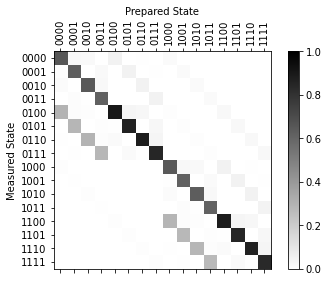

In [7]:
# Plot assignment matrix
mitigator.plot_assignment_matrix()

<AxesSubplot:xlabel='Prepared State', ylabel='Measured State'>

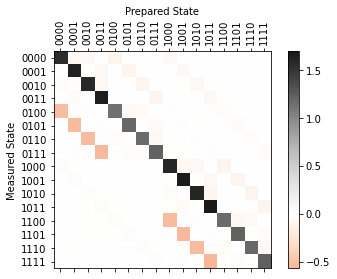

In [8]:
# Plot mitigation matrix
mitigator.plot_mitigation_matrix()

### Assignment Fidelity

The mitigator also can compute the assignment fidelity for all qubits, or subsets of qubits

In [9]:
# 4-qubit measurement assignment fidelity
print('F_a = {:.3f}'.format(mitigator.assignment_fidelity()))

F_a = 0.751


In [10]:
# Single-qubit measurement assignment fidelities
for i in range(num_qubits):
    print('F_a({}) = {:.3f}'.format(i, mitigator.assignment_fidelity([i])))

F_a(0) = 0.974
F_a(1) = 0.971
F_a(2) = 0.815
F_a(3) = 0.978


### Mitigation Overhead

We can also compute the mitigation overhead for given measurement error rates.
The overhead is the number of additional shots required to obtain expectation value estimates with the same statistical accuracy as unmitigated expectation values

In [11]:
# 4-qubit expectation values
mitigator.mitigation_overhead()

8

## Expectation Values with mitigation

To demonstrate mitigation we will use an example of estimating the fidelity of a graph state.

We can do this by computing the stabilizers of a graph state, and defining our observable to be $\sum_{i=1}^N S_i / N$ for $N=2^n$

In [12]:
def coupling_graph(backend, max_qubits):
    """Get coupling graph for a backend."""
    return np.unique(
        [sorted(i) for i in backend.configuration().coupling_map
         if max(i) < max_qubits], axis=0).tolist()

First we generate a graph state circuit for the native coupling map of a backend

In [13]:
from qiskit import QuantumCircuit

num_qubits = 4
graph = coupling_graph(backend, num_qubits)

graph_state = QuantumCircuit(num_qubits)
graph_state.h(range(num_qubits))
for i, j in graph:
    graph_state.cz(i, j)
graph_state.h(range(num_qubits))
graph_state.draw()

┌───┐   ┌───┐          
q_0: ┤ H ├─■─┤ H ├──────────
     ├───┤ │ └───┘┌───┐     
q_1: ┤ H ├─■───■──┤ H ├─────
     ├───┤     │  └───┘┌───┐
q_2: ┤ H ├─────■────■──┤ H ├
     ├───┤          │  ├───┤
q_3: ┤ H ├──────────■──┤ H ├
     └───┘             └───┘

Next we use the Clifford class to find the stabilizers for this state

In [14]:
clifford = qi.Clifford(graph_state)
stabilizers = clifford.stabilizer.pauli
print(stabilizers.to_labels())

['IIXZ', 'IXZX', 'XZXI', 'ZXII']


Next we convert the stabilizers to a SparsePauliOp observable

In [15]:
N = len(stabilizers)
stab_op = qi.SparsePauliOp(stabilizers, N * [1 / N])

### Target fidelity

First we compute the fidelity based on the noise model without measurement error

In [16]:
from qiskit.providers.aer.utils import insert_noise

state_ideal = qi.Statevector.from_instruction(graph_state)
state_target = qi.DensityMatrix.from_instruction(insert_noise(graph_state, noise_model, transpile=True))
F_target = qi.state_fidelity(state_ideal, state_target)
print('F(target) = {:.3f}'.format(F_target))

F(target) = 0.960


### Running the experiment

Next we run the expectation value experiment with readout and gate noise, and we will process the results both with and without error mitigation

In [17]:
shots = 8192
stab_exp = ExpectationValue(stab_op, initial_state=graph_state)
stab_exp.execute(sim, shots=shots, noise_model=noise_model)

In [18]:
expval_noise, error_noise = stab_exp.run_analysis()
print('F(no-mit) = {:.3f} \u00B1 {:.3f}'.format(expval_noise, error_noise))

F(no-mit) = 0.636 ± 0.004


In [19]:
expval_noise, error_noise = stab_exp.run_analysis(mitigator=mitigator)
print('F(no-mit) = {:.3f} \u00B1 {:.3f}'.format(expval_noise, error_noise))

F(no-mit) = 0.973 ± 0.087


## Snapshot expectation value experiment

We also include a snapshot method for expectation value experiments that can take advantage of the Aer simulator snapshot instructions to perform a measurement more efficiently.

This will include the effect of gate noise, but not sampling noise or readout noise

In [20]:
# Run without noise
exp_snap = ExpectationValue(stab_op, initial_state=graph_state, method='snapshot')
expval, error = exp_snap.run(sim, shots=shots, noise_model=noise_model)
print('F(snapshot) = {:.3f} \u00B1 {:.3f}'.format(expval, error))

F(snapshot) = 0.968 ± 0.002


In [21]:
for i in exp_snap.generator.circuits():
    print(i.draw())

     ┌───┐   ┌───┐           ░  ░ 
q_0: ┤ H ├─■─┤ H ├───────────░──░─
     ├───┤ │ └───┘┌───┐      ░  ░ 
q_1: ┤ H ├─■───■──┤ H ├──────░──░─
     ├───┤     │  └───┘┌───┐ ░  ░ 
q_2: ┤ H ├─────■────■──┤ H ├─░──░─
     ├───┤          │  ├───┤ ░  ░ 
q_3: ┤ H ├──────────■──┤ H ├─░──░─
     └───┘             └───┘ ░  ░ 
c: 4/═════════════════════════════
                                  
